In [1]:
import sys
sys.path.append("D:\\Repositories\\PWRG\\python-qutip-helpers")

import networkx as nx
import qutip as qt
import itertools as itt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import scipy as sc
import annealing

# Directory to save the results in
root = "."

In [2]:
mpl.rcParams.update({'font.size':20})

In [3]:
mpl.rcParams.update({'font.size':20})

In [4]:
print("networkx v %s" % nx.__version__)
print("qutip v %s" % qt.__version__)
print("numpy v %s" % np.__version__)
print("scipy v %s" % sc.__version__)

networkx v 2.5
qutip v 4.6.2
numpy v 1.20.1
scipy v 1.6.2


In [5]:
# Sanitize array
def san(a, tol):
    arr = a.copy()
    arr[np.abs(arr) < tol] = 0.0
    return arr

# Count the number of zero crossings in 1D array
def find_crossings(arr):
    s = np.sign(san(arr, 1e-5))
    s = [e for e in s if e != 0.0]
    flips = np.sum(((np.roll(s, 1) - s) != 0).astype(int))
    if s[0] == s[-1]:
        return flips
    return flips-1

# Transverse field default schedule
def A(s, p):
    if s < 0:
        return 1.0
    elif s >= 0 and s <= 1:
        return (1.0-s)
    else:
        return 0.0

# Longitudinal field default schedule
def B(s, p):
    if s < 0:
        return 0.0
    elif s >= 0 and s <= 1:
        return s
    else:
        return 1.0

def C(s, p):
    if s < 0:
        return 0.0
    elif s >= 0 and s <= 1:
        return s*(1 - s)
    else:
        return 0

# Transverse field default schedule with pause
def Amod(s, p):
    spause = p["spause"]
    if s < spause:
        return 1.0
    elif s >= spause and s <= 1:
        return 1.0 - (s - spause)/(1 - spause)
    else:
        return 0.0

# Longitudinal field default schedule with pause
def Bmod(s, p):
    spause = p["spause"]
    if s < spause:
        return 0.0
    elif s >= spause and s <= 1:
        return (s - spause)/(1 - spause)
    else:
        return 1.0

# Crossing Z schedule
def zcrossing(s, p):
    spause = p["spause"]
    if s < 0:
        return -spause/(1 - spause)
    elif s >= 0 and s <= 1:
        return (s - spause)/(1 - spause)
    else:
        return 1.0

# AQA instance
def init_aqa(R):
    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hx', R, A)
    
    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hz', z_vals[i]*R, B)
    
    for i,e in enumerate(Hobj.getEdges()):
        Hobj.setCoef(e, 'Jzz', J_vals[i]*R, B)

# DQA instance
def init_dqa(R, choice):
    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hx', R, Amod)
    Hobj.setCoef(choice, 'hx', 0.0, Amod)

    for i in Hobj.getNodes():
        Hobj.setCoef(i, 'hz', z_vals[i]*R, Bmod)
    Hobj.setCoef(choice, 'hz', z_vals[choice]*R, zcrossing)

    for i,e in enumerate(Hobj.getEdges()):
        Hobj.setCoef(e, 'Jzz', J_vals[i]*R, Bmod)

In [6]:
import pickle

def pickleWrite(obj, filename):
    # Open file for writing in binary
    fd = open(filename,"wb")
    
    # Pickle the object
    pickle.dump(obj,fd)
    
    # Write to file
    fd.close()
    
    return filename

def pickleRead(filename):
    # Read file in binary
    fd = open(filename,"rb")
    
    # Unpickle
    obj = pickle.load(fd)
    fd.close()
    
    return obj

In [7]:
# Save data
instance_data, all_graphs, instances, graph_binning = pickleRead("total-instance-data.bin")

In [8]:
index = 328
count = 10
instances[count][index]
G = all_graphs[count][instances[count][index]['graph']]
z_vals = instances[count][index]['coefficients'][0]
J_vals = instances[count][index]['coefficients'][1]
Hobj = annealing.IsingGraph({1:G, 2:G})

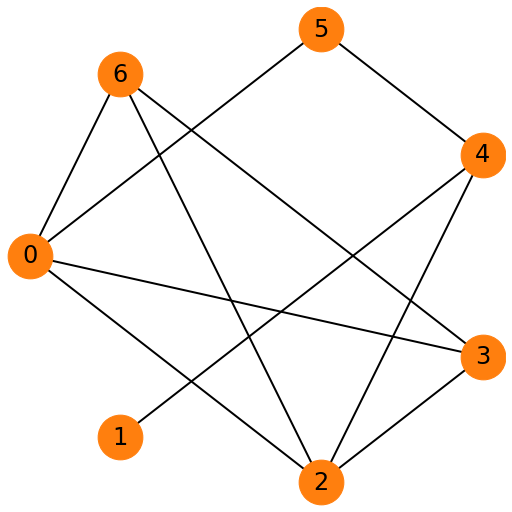

In [9]:
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(7,7))
        
# Get layout first as it is randomly generated
#L = nx.spring_layout(self.graph_family[n])
#L = nx.planar_layout(self.graph_family[n])
#L = nx.kamada_kawai_layout(self.graph_family[n])
L = nx.shell_layout(Hobj.graph_family[1])

Hobj._update_node_labels()
nx.draw(
    Hobj.graph_family[1],
    pos=L,
    with_labels=True,
    node_color="C1",
    node_size=2000,
    width=2,
    labels=Hobj.node_labels,
    font_weight="normal",
    font_size=24,
    ax=ax
)
plt.show()

## AQA Algorithm Spectrum

In [10]:
init_aqa(1)

In [11]:
npts = 101
n = 7
sv = np.linspace(0, 1, npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
msx = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    sx = Hobj.getOperator(j, 'hx')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])
        msx[j,i] = sx.overlap(V[i][0])


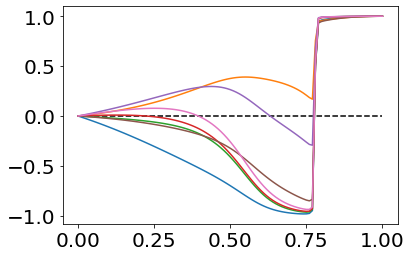

In [12]:
plt.plot(sv, E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv, msz[i])


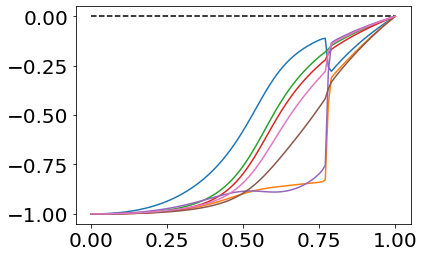

In [13]:
plt.plot(sv, E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv, msx[i])


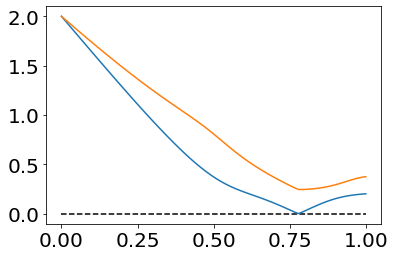

In [14]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))


## DQA Algorithm Spectrum

In [15]:
init_dqa(1, 0)

In [16]:
npts = 101
n = 7
p = {'spause':0.2}
sv = np.linspace(0, 1, npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s, p).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

# individual components of magnetization for each qubit
msz = np.zeros((n, npts))
msx = np.zeros((n, npts))
for j in range(n):
    sz = Hobj.getOperator(j, 'hz')
    sx = Hobj.getOperator(j, 'hx')
    for i,s in enumerate(sv):
        msz[j,i] = sz.overlap(V[i][0])
        msx[j,i] = sx.overlap(V[i][0])

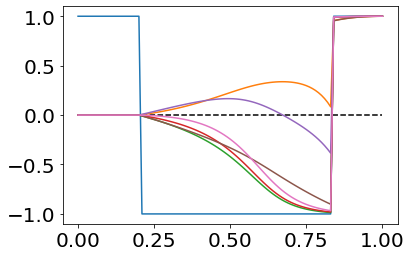

In [17]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msz[i])

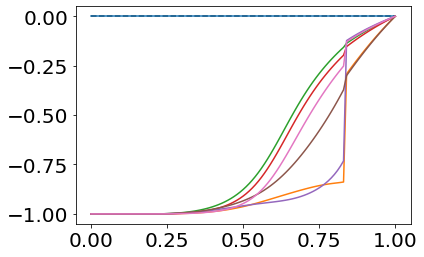

In [18]:
plt.plot(sv,E[:,0] - E[:,0], "k--")
for i in range(n):
    plt.plot(sv,msx[i])

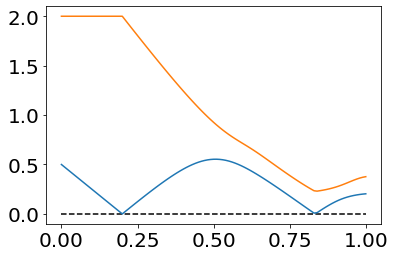

In [19]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

## AQA Single Run Dynamics

In [20]:
init_aqa(1.0)

# Get initial state
p = {'spause':0.2}
Es, Vs = Hobj.getHamiltonian(0, p).eigenstates()
Vinit = Vs[0]

Es, Vs = Hobj.getHamiltonian(1, p).eigenstates()
Vsol = Vs[0]

In [21]:
npts = 101
sv = np.linspace(0, 1, npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

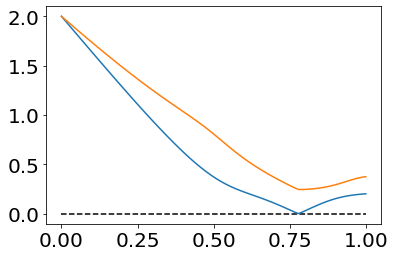

In [22]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

In [23]:
p = {'tan': 100.0}
npts = 100
Qevo = Hobj.getQobjEvo(p)
tlist = np.linspace(0, p['tan'], npts)
result = qt.sesolve(Qevo, Vinit, tlist)

In [24]:
# overlap with problem ground state
p0 = np.zeros(npts)
for i, t in enumerate(tlist):
    p0[i] = abs(result.states[i].overlap(Vsol))**2

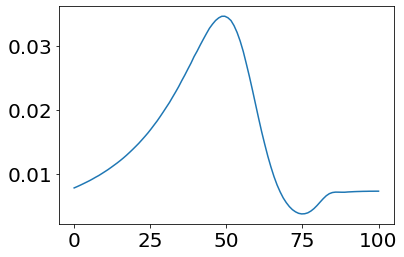

In [25]:
plt.plot(tlist, p0)

## DQA Single Run Dynamics

In [26]:
init_dqa(1.0, 0)

# Get initial state
p = {'spause':0.2}
Es, Vs = Hobj.getHamiltonian(0, p).eigenstates()
Vinit = Vs[0]

Es, Vs = Hobj.getHamiltonian(1, p).eigenstates()
Vsol = Vs[0]

In [27]:
npts = 101
sv = np.linspace(0, 1, npts)
E=[]
V=[]
for s in sv:
    Es,Vs = Hobj.getHamiltonian(s, p).eigenstates()
    E.append(Es)
    V.append(Vs)
E = np.array(E)

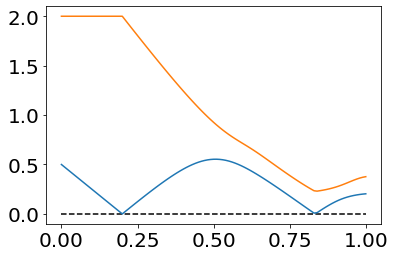

In [28]:
plt.plot(sv, E[:,0] - E[:,0], 'k--')
for i in range(2):
    plt.plot(sv, (E[:,i+1] - E[:,0])/(2*np.pi))

In [29]:
p = {'tan': 100.0, 'spause': 0.2}
npts = 100
Qevo = Hobj.getQobjEvo(p)
tlist = np.linspace(0, p['tan'], npts)
result = qt.sesolve(Qevo, Vinit, tlist)

In [30]:
# overlap with problem ground state
p0 = np.zeros(npts)
for i, t in enumerate(tlist):
    p0[i] = abs(result.states[i].overlap(Vsol))**2

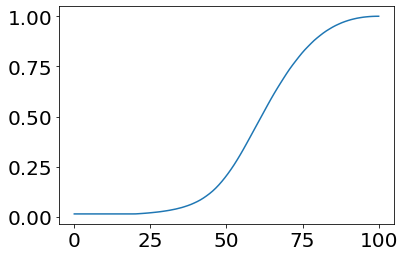

In [31]:
plt.plot(tlist, p0)

In [32]:
ntanpts = 32
tan_pts = np.logspace(0, 3, ntanpts)
npts = np.array([int(tan+1) for tan in tan_pts]) # want ~1 ns resolution for 1 GHz energy scale
print(tan_pts)
print(npts)

[   1.            1.24960914    1.56152301    1.95129342    2.4383541
    3.04698957    3.80754602    4.75794431    5.94557071    7.42963951
    9.28414545   11.60155302   14.4974067    18.11609194   22.6380341
   28.28869435   35.34981105   44.17344703   55.19954321   68.97785379
   86.19535665  107.7105056   134.59603242  168.19243249  210.17480113
  262.63635277  328.19278725  410.11270706  512.4805877   640.40042712
  800.25022782 1000.        ]
[   2    2    2    2    3    4    4    5    6    8   10   12   15   19
   23   29   36   45   56   69   87  108  135  169  211  263  329  411
  513  641  801 1001]


## AQA/DQA Final State Fidelity Comparison

In [33]:
ntanpts = 32
#tan_pts = np.logspace(1, 4, ntanpts)
tan_pts = np.logspace(0, 3, ntanpts)
npts = np.array([int(tan+1) for tan in tan_pts]) # want 1 ns resolution for 1 GHz energy scale

# Get AQA initial state
init_aqa(1.0)
Es, Vs = Hobj.getHamiltonian(0).eigenstates()
Vinit_aqa = Vs[0]
Es, Vs = Hobj.getHamiltonian(1).eigenstates()
Vsol_aqa = Vs[0]

# Get DQA initial state
init_dqa(1.0, 0)
p = {'spause':0.2}
Es, Vs = Hobj.getHamiltonian(0, p).eigenstates()
Vinit_dqa = Vs[0]
Es, Vs = Hobj.getHamiltonian(1, p).eigenstates()
Vsol_dqa = Vs[0]

aqa_probs0 = np.zeros(ntanpts)
dqa_probs0 = np.zeros(ntanpts)
for i, tan in enumerate(tan_pts):
    n = npts[i]
    
    # AQA
    init_aqa(1.0)
    p = {'tan': tan}
    Qevo = Hobj.getQobjEvo(p)
    tlist = np.linspace(0, tan, n)
    result = qt.sesolve(Qevo, Vinit_aqa, tlist)
    aqa_probs0[i] = abs(result.states[-1].overlap(Vsol_aqa))**2
    
    # DQA
    init_dqa(1.0, 0)
    p = {'tan': tan, 'spause': 0.2}
    Qevo = Hobj.getQobjEvo(p)
    tlist = np.linspace(0, tan, n)
    result = qt.sesolve(Qevo, Vinit_dqa, tlist)
    dqa_probs0[i] = abs(result.states[-1].overlap(Vsol_dqa))**2
    

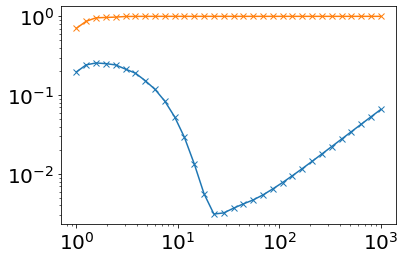

In [37]:
plt.loglog(tan_pts, aqa_probs0, "C0-")
plt.loglog(tan_pts, aqa_probs0, "C0x")
plt.loglog(tan_pts, dqa_probs0, "C1-")
plt.loglog(tan_pts, dqa_probs0, "C1x")
plt.savefig("prob-vs-tan.png")

In [35]:
tts_aqa = np.zeros(ntanpts)
tts_dqa = np.zeros(ntanpts)
for i, tan in enumerate(tan_pts):
    tts_aqa[i] = tan*np.log(1 - 0.99)/np.log(1 - aqa_probs0[i])
    tts_dqa[i] = 7*tan*np.log(1 - 0.99)/np.log(1 - dqa_probs0[i])

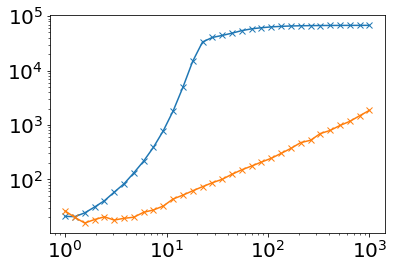

In [38]:
plt.loglog(tan_pts, tts_aqa, "C0-")
plt.loglog(tan_pts, tts_aqa, "C0x")
plt.loglog(tan_pts, tts_dqa, "C1-")
plt.loglog(tan_pts, tts_dqa, "C1x")
plt.savefig("tts-vs-tan.png")